## Written by wanping7

In [1]:
from datetime import datetime

# data process
import numpy as np, pandas as pd
from  datetime import datetime, timedelta

# visualize
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config ZMQInteractiveShell.ast_node_interactivity='all'

# sys
import os, sys


# 大小设置
sns.set(rc={'figure.figsize':(13,7)})
# 风格设置
sns.set_style("whitegrid")


PATH = "../data/"

## 结论

- 数据无缺失
- 数据无异常
- 数据分布近似正态
- 128维实值向量
    - 所有商品不同文本或图像之间的相关性（比较意义不大）
    - 相关性都非常小
- 商品（抽取前200商品）
    - 文本相关性大于0.6的商品占9.5%
    - 图像相关性大于0.6的商品占3.9%

In [2]:
TRAIN_PATH = PATH + "underexpose_train/"

# 商品特征

- underexpose_item_feat.csv 

   - item_id：第0列
   - txt_vec：第1-128列
   - img_vec：第129-256列

## 1 缺失情况

In [3]:
item_feat = pd.read_csv(TRAIN_PATH + "underexpose_item_feat.csv", header=None)
item_feat.columns = ["item_id"] + ["vec_" + str(i) for i in item_feat.columns[1:]]
print("缺失情况：", item_feat.isna().sum().sum())
item_feat["vec_1"] = item_feat["vec_1"].map(lambda x:x[1:]).astype("float64")
item_feat["vec_129"] = item_feat["vec_129"].map(lambda x:x[1:]).astype("float64")
item_feat["vec_128"] = item_feat["vec_128"].map(lambda x:x[:-1]).astype("float64")
item_feat["vec_256"] = item_feat["vec_256"].map(lambda x:x[:-1]).astype("float64")
item_feat.head(2)

缺失情况： 0


,item_id,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,vec_9,...,vec_247,vec_248,vec_249,vec_250,vec_251,vec_252,vec_253,vec_254,vec_255,vec_256
0,42844,4.514945,-2.383720,0.500414,0.407068,-1.995229,0.109078,-0.691775,2.227460,-6.437974,...,-3.374727,-1.506969,-1.820180,-3.024644,0.445263,0.013933,-1.300239,2.759948,2.056171,0.508703
1,67898,-2.002905,-0.929881,0.790017,-1.380895,-0.510463,-1.810096,1.363962,0.497401,-4.038903,...,-0.538330,-2.620164,1.277195,0.601015,-0.345312,0.993457,1.351633,2.162675,2.768597,-0.937197


## 2 异常

In [21]:
item_feat.iloc[:, 1:].min().min()
item_feat.iloc[:, 1:].max().max()

-18.74911880493164

19.012435913085934

In [24]:
(item_feat.iloc[:, 1:]>10).sum().sum()

859

In [25]:
(item_feat.iloc[:, 1:]<-10).sum().sum()

1296

## 3 分布

- 对每一列做概率密度直方图

画图耗时： 0:00:14.614836


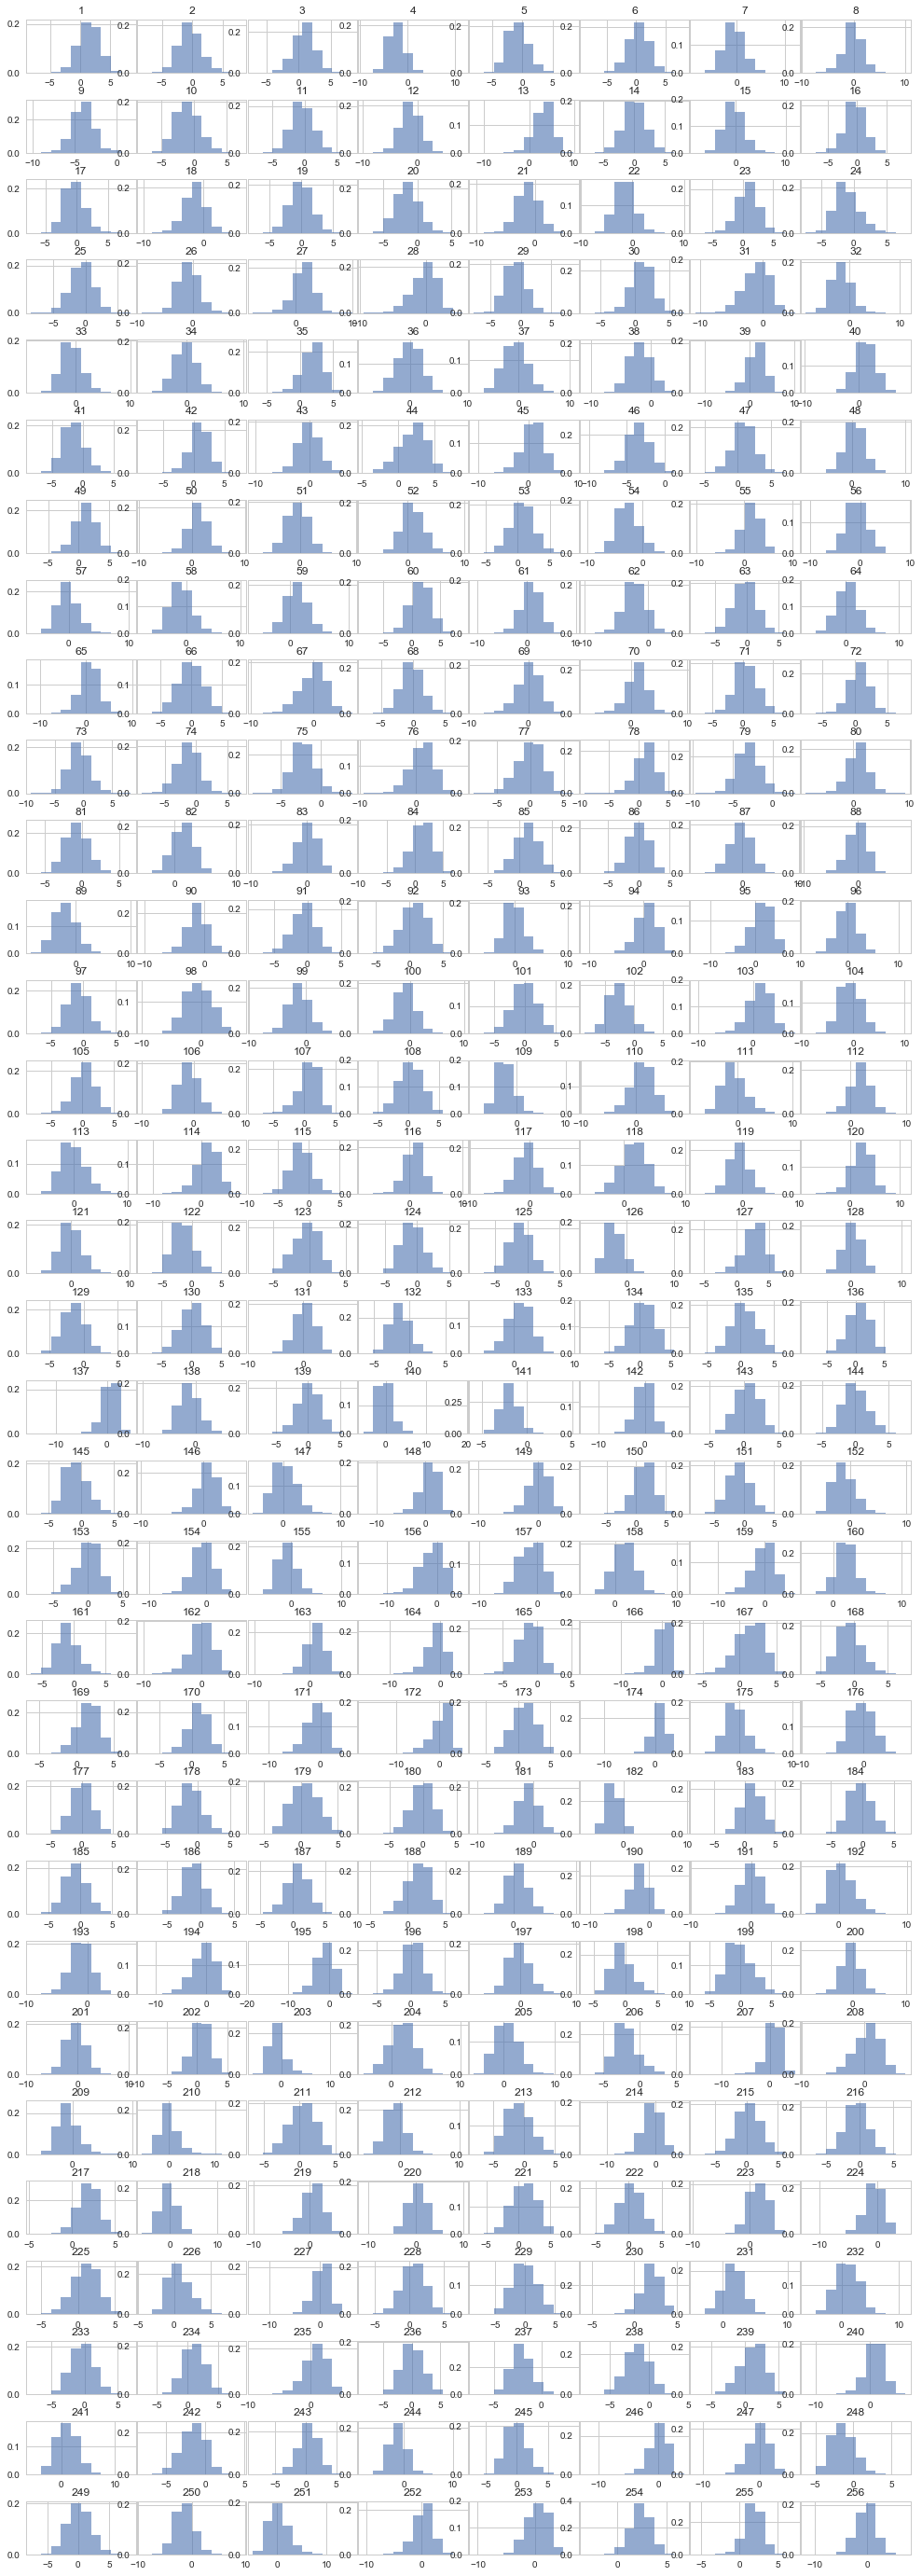

In [4]:
plot_time = datetime.now()
fig, axs = plt.subplots(32,8, figsize=(17, 50), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.01)

axs = axs.ravel()

for i in range(256):
    x = axs[i].hist(item_feat.iloc[:, i+1], density=True, alpha=0.6)
    x = axs[i].set_title(str(1+i))
print("画图耗时：", datetime.now()-plot_time)

画图耗时： 0:00:14.863850


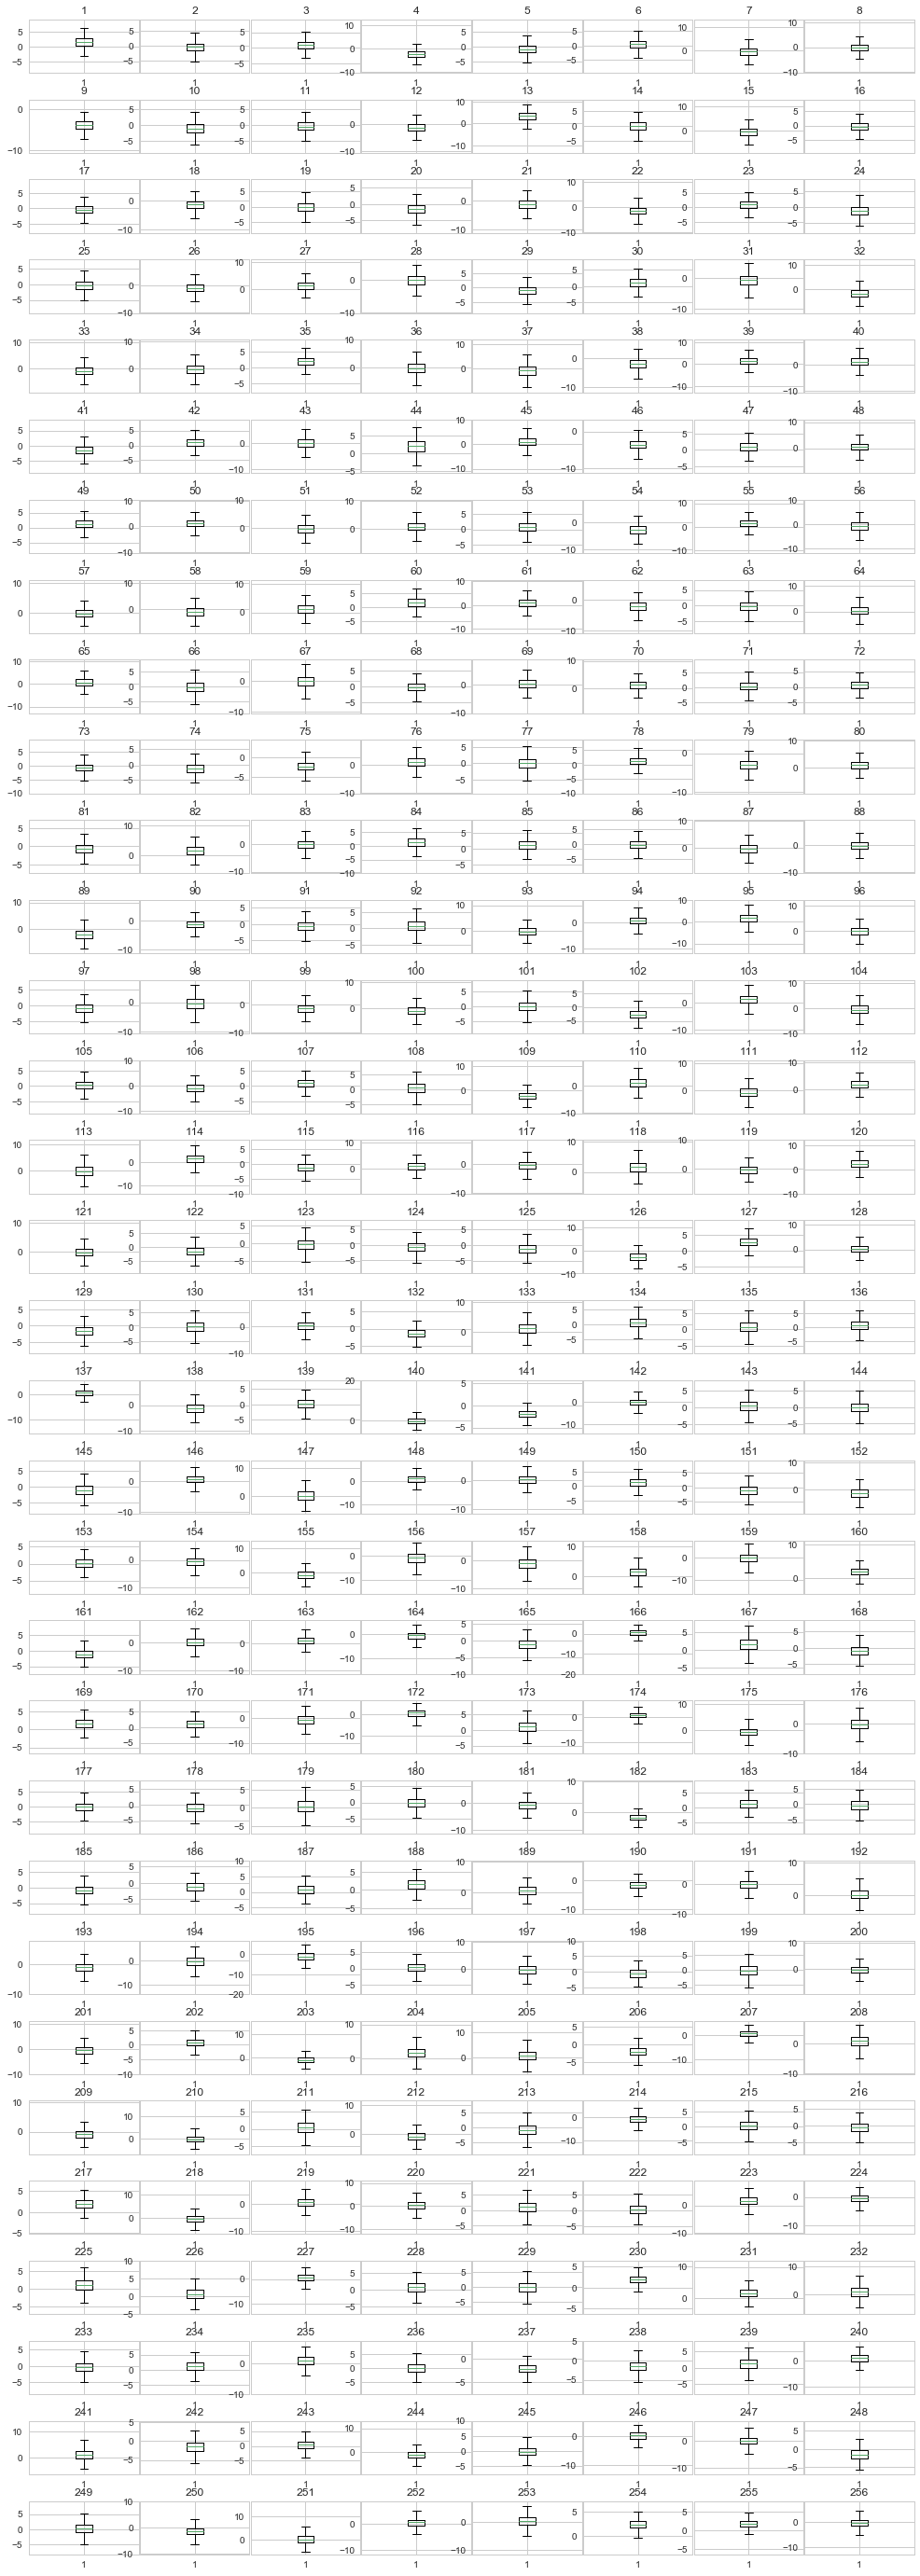

In [16]:
plot_time = datetime.now()
fig, axs = plt.subplots(32,8, figsize=(17, 50), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.01)

axs = axs.ravel()

for i in range(256):
    x = axs[i].boxplot(item_feat.iloc[:, i+1])
    x = axs[i].set_title(str(1+i))
print("画图耗时：", datetime.now()-plot_time)

## 4 文本与图像相关性


### 文本相关性

- txt_vec

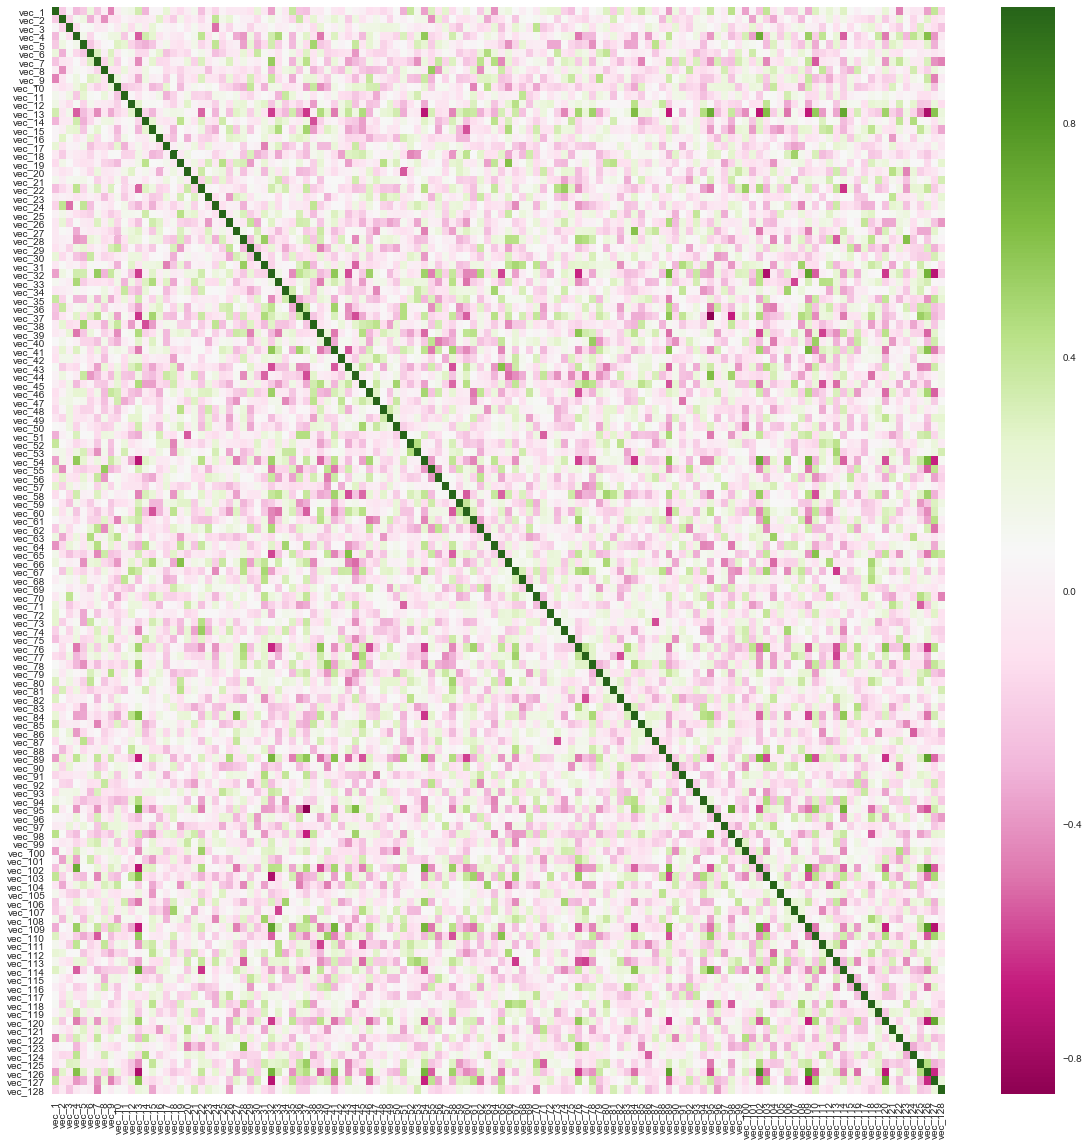

In [7]:
corr_matrix_txt = item_feat.iloc[:,1:129].corr()
# corr_matrix_txt.style.background_gradient(cmap='coolwarm').set_precision(2)
# 大小设置
sns.set(rc={'figure.figsize':(20, 20)})
# 风格设置
x = sns.set_style("whitegrid")
x = sns.heatmap(corr_matrix_txt, 
                xticklabels=corr_matrix_txt.columns.values,
                yticklabels=corr_matrix_txt.columns.values,
                cmap="PiYG")

### 图片相关性

- img_vec

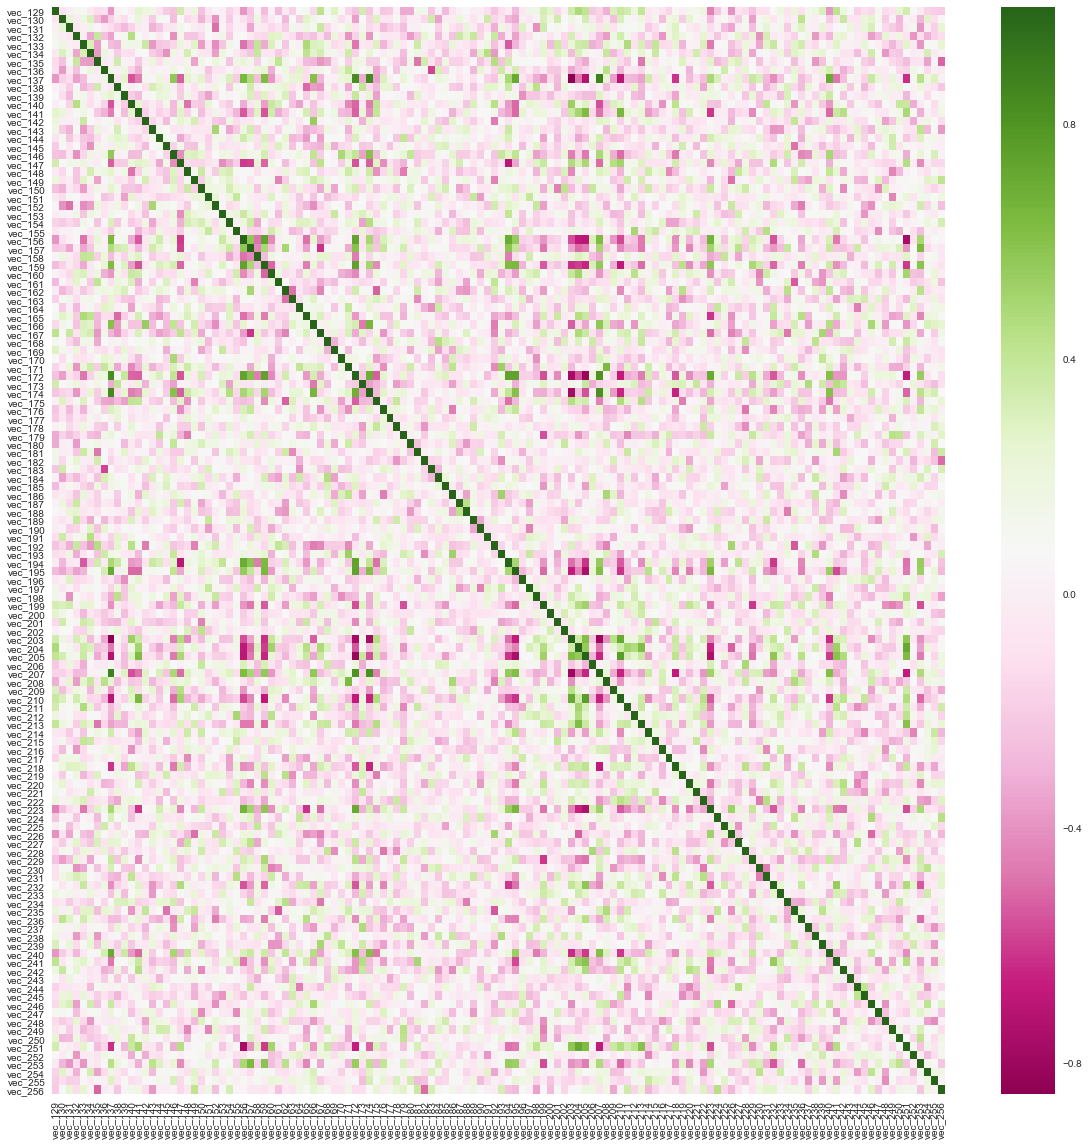

In [8]:
corr_matrix_img = item_feat.iloc[:, 129:].corr()
# corr_matrix_img.style.background_gradient(cmap='coolwarm').set_precision(2)
# 大小设置
sns.set(rc={'figure.figsize':(20, 20)})
# 风格设置
x = sns.set_style("whitegrid")
x = sns.heatmap(corr_matrix_img, 
                xticklabels=corr_matrix_img.columns.values,
                yticklabels=corr_matrix_img.columns.values,
                cmap="PiYG")

### 文本与图片交叉相关性

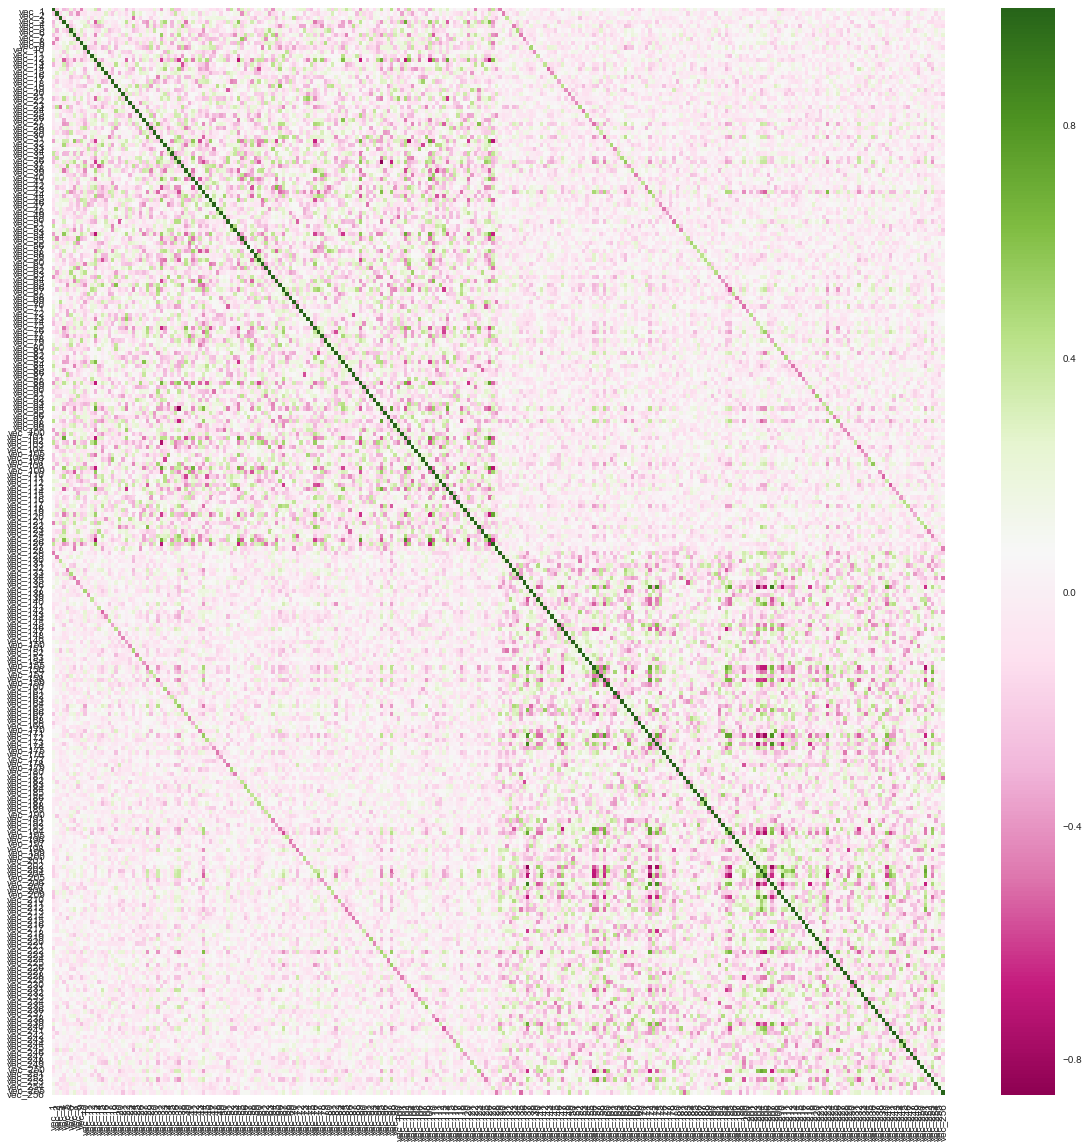

In [9]:
corr_matrix_cross = item_feat.iloc[:, 1:].corr()
# corr_matrix_cross.style.background_gradient(cmap='coolwarm').set_precision(2)
# 大小设置
sns.set(rc={'figure.figsize':(20, 20)})
# 风格设置
x = sns.set_style("whitegrid")
x = sns.heatmap(corr_matrix_cross, 
                xticklabels=corr_matrix_cross.columns.values,
                yticklabels=corr_matrix_cross.columns.values,
                cmap="PiYG")

## 5 商品相关性

In [10]:
def get_redundant_pairs(corr_matrix):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = corr_matrix.columns
    for i in range(0, corr_matrix.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(corr_matrix, n=5):
    au_corr = corr_matrix.abs().unstack()
    labels_to_drop = get_redundant_pairs(corr_matrix)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n], 100* au_corr[au_corr>0.6].shape[0]/au_corr.shape[0]

### 文本

In [11]:
corr_matrix_item_txt = item_feat.set_index(["item_id"]).iloc[:200, :128].T.corr()
print("Top Absolute Correlations：")
top10, percent_60 = get_top_abs_correlations(corr_matrix_item_txt, 10)
print("=======================================================>Top10相关商品：")
top10
print("=======================================================>相关系数>0.6商品占比：", str(percent_60)+"%")

Top Absolute Correlations：
=======================================================>Top10相关商品：


item_id  item_id
20663    39519      0.973651
         107837     0.948499
92665    62142      0.947190
39519    107837     0.937884
113217   100268     0.936050
58537    1460       0.933004
100060   95657      0.931748
60883    51002      0.924717
81507    90687      0.924487
27610    47499      0.917700
dtype: float64

=======================================================>相关系数>0.6商品占比： 9.547738693467336%


### 图像

In [12]:
corr_matrix_item_img = item_feat.set_index(["item_id"]).iloc[:200, 128:].T.corr()
print("Top Absolute Correlations：")
top10, percent_60 = get_top_abs_correlations(corr_matrix_item_img, 10)
print("=======================================================>Top10相关商品：")
top10
print("=======================================================>相关系数>0.6商品占比：", str(percent_60)+"%")

Top Absolute Correlations：
=======================================================>Top10相关商品：


item_id  item_id
63005    66205      0.965716
100060   39519      0.957081
51915    60883      0.949791
63005    68778      0.944829
100268   91106      0.937381
54655    68778      0.933107
78349    61160      0.931327
39519    95657      0.929550
54655    63005      0.925701
68778    66205      0.925100
dtype: float64

=======================================================>相关系数>0.6商品占比： 3.9145728643216082%
